Though there are many possible [supervised learning model types](https://en.wikipedia.org/wiki/Supervised_learning#Approaches_and_algorithms) to choose from, gradient boosted models (GBMs) are almost always my first choice. In many cases, they end up outperforming other options, and even when they don't, it's rare that a properly tuned GBM is far behind the best model.

At a high level, the way GBMs work is by starting with a rough prediction and then building a series of decision trees, with each tree in the series trying to correct the prediction error of the tree before it. There's more detailed descriptions of the mechanics behind the algorithm out there, but this series of posts is intended to give more of an intuitive understanding of what the algorithm does.

In [1]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

### Building a dataset for the example

For this series, I'll be using a synthetic 2-dimensional classification dataset generated using scikit-learn's `make_classification()`. For performance estimation, I'll hold back 20% of the generated data as a test set.

In [2]:
raw_data, raw_target = make_classification(n_samples=20000, n_features=2, n_informative=2, n_redundant=0, 
                                           n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, 
                                           flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, 
                                           shuffle=False, random_state=2)
train, test, train_t, test_t = train_test_split(raw_data, raw_target, test_size=0.2, random_state=2)
pd.DataFrame(np.hstack([raw_data, raw_target[:,None]]), columns=['x', 'y', 'target']).head(3)

,x,y,target
0,-1.050819,-0.828094,0
1,-0.184011,-1.904585,0
2,-1.553358,0.294934,0


This particular set of parameters ends up creating 2 Gaussian blobs of points for each of the target classes, with a few difficult areas to classify where there's some heavy overlap in the two groups. In addition, within each Gaussian blob, 1% of the examples have had their labels flipped, creating situations where a good classifier ought to come up with the "wrong" prediction. Both the overlap and the flipped areas create ample opportunities for models to overfit if they attempt to get all the individual training examples correct rather than find good general classification rules.

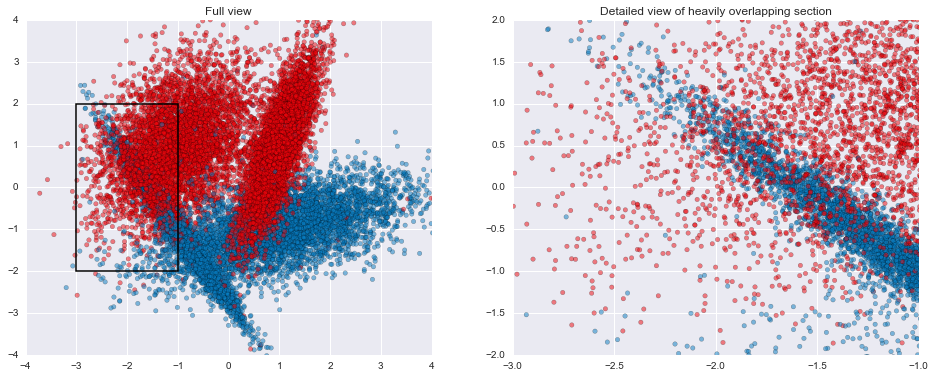

In [3]:
my_cm = sns.diverging_palette(h_neg=245, h_pos=12, s=99, l=50, sep=15, n=16, center='light', as_cmap=True)
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title("Full view")
plt.scatter(raw_data[:,0], raw_data[:,1], c=raw_target, alpha=0.5, cmap=my_cm)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axhspan(-2, 2, 0.125, 0.375, fill=False, lw=1.5)

plt.subplot(1,2,2)
plt.title("Detailed view of heavily overlapping section")
plt.scatter(raw_data[:,0], raw_data[:,1], c=raw_target, alpha=0.5, cmap=my_cm)
plt.xlim(-3, -1)
plt.ylim(-2, 2)

plt.show()

### GBM parameters

Now that we have a dataset to work with, let's consider the parameters GBMs have for us to tweak. Arguably, the most important two are the **number of trees** and the **learning rate**. The former is fairly straightforward: it simply corresponds to the number of trees that will be fit in series to correct the prediction errors. The learning rate corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier $0 \lt LR \leq 1$. 

For example, if the current prediction for a particular example is $0.2$ and the next tree predicts that it should actually be $0.8$, the correction would be $+0.6$. At a learning rate of $1$, the updated prediction would be the full $0.2 + 1(0.6) = 0.8$, while a learning rate of $0.1$ would update the prediction to be $0.2 + 0.1(0.6) = 0.26$.

Beyond these two parameters, we can tweak things relating to the model like **subsampling rows** (i.e., including a random portion of the training set at each tree in the series) and **loss function** used to assess performance, as well as things relating to individual trees like **maximum tree depth**, **minimum samples to split a node**, **minimum samples in a leaf node**, and **subsampling features** (i.e., only considering a set of the features when splitting nodes in the tree to provide some extra randomness). These parameters can also have a big impact once you've settled on a decent tree count/learning rate combo, but they tend to be a second step in the process. As a rule of thumb, using some small amount of subsampling (e.g., 80-90% of the data at each step) and keeping trees relatively shallow (max depth between 2-5) tends to be fairly effective in most cases.

### Why lower learning rates?

The multiplicative nature of the learning rate acts at odds with the number of trees: for a learning rate $L$ and a number of trees $t$, if we decrease the learning rate to $\frac{L}{n}$ then we'll need something on the order of $nt$ trees to maintain the same level of performance. Because each tree in a GBM is fit in series, the training time of the model grows linearly with the number of trees (i.e., if it takes you $m$ minutes to fit a model on 100 trees, then it should take roughly $2m$ minutes to fit the same model on 200 trees). Why then would we want to lower the learning rate?

To answer that, let's try fitting a few GBMs on our sample data. In each case, we'll use **500 trees** of **maximum depth 3** and use a **90% subsample** of the data at each stage, but we'll do a **low learning rate of 0.05** in one, a **high learning rate of 0.5** in a second, and the **maximum of 1** in the third. After fitting each model, we'll also get the predictions from each tree in the series, as well as the final predictions.

In [4]:
common_args = {'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9, 'random_state': 2}

models = [('max', GradientBoostingClassifier(learning_rate=1, **common_args)),
          ('high', GradientBoostingClassifier(learning_rate=0.5, **common_args)),
          ('low', GradientBoostingClassifier(learning_rate=0.05, **common_args)),
         ]
stage_preds = {}
final_preds = {}

for mname, m in models:
    m.fit(train, train_t)
    stage_preds[mname] = {'train': list(m.staged_predict_proba(train)),  'test': list(m.staged_predict_proba(test))}
    final_preds[mname] = {'train': m.predict_proba(train),  'test': m.predict_proba(test)}

First, let's take a look at the effect of the learning rates on the predictions at each stage. The plots below show histograms for predictions on the 18,000 training examples at trees 1, 5, 50, and 100, and the final predictions at tree 500.

From the tree 1 plot, the effect of the learning rate is immediately apparent. All predictions are initialized to approximately $0.5$ since the target is split roughly in half, and so after 1 tree, each prediction will fall between $0.5-LR$ and $0.5+LR$. Because we are using relatively shallow trees with the max depth set to 3, none of the leaf nodes end up being purely 0s or 1s, however. 

One other interesting thing to note in the tree 1 plot is that the underlying tree that is constructed is identical in each of the models. You can see this from the identically shaped but differently spaced histograms for the 0.5 and 1.0 learning rate models.

By tree 50, the higher learning rates have already pushed most of the predictions out to the 0/1 ends of the spectrum, while only the very easiest examples are even starting to approach 0 or 1 in the lower learning rate model. In the final model, all of the models have a set of points for which they are feeling relatively certain, though the lower learning rate model has been a little more conservative than the others.

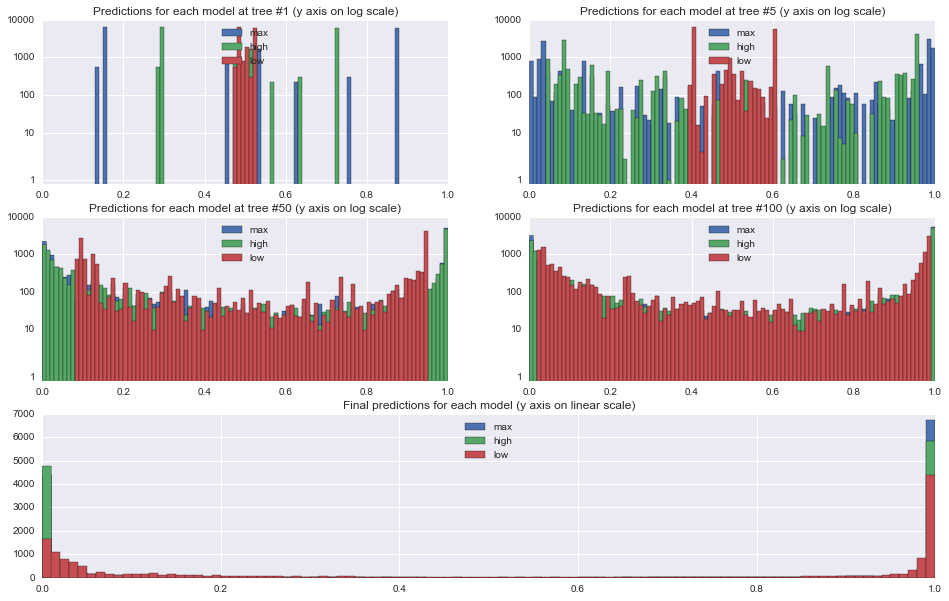

In [5]:
def frame(i=0, log=False):
    for mname, _ in models:
        plt.hist(stage_preds[mname]['train'][i][:,1], bins=np.arange(0,1.01,0.01), label=mname, log=log)
    plt.xlim(0,1)
    plt.ylim(0,8000)
    if log:
        plt.ylim(0.8,10000)
        plt.yscale('symlog')
        plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
    plt.legend(loc='upper center')
    return

plt.figure(figsize=(16,10))
for pos, fnum in enumerate((1, 5, 50, 100), 0):
    plt.subplot2grid((3,2), (pos/2, pos%2))
    frame(fnum-1, True)
    plt.title("Predictions for each model at tree #%d (y axis on log scale)" % fnum)

plt.subplot2grid((3,2), (2,0), colspan=2)
plt.title("Final predictions for each model (y axis on linear scale)")
frame(-1, False)
plt.ylim(0,7000)
plt.show()

### Model performance

To assess model performance, we'll measure the area under the ROC curve for each model to get a general sense of how accurately each model can rank order the examples with different line styles corresponding to each of the 3 different models. We'll also look separately at the train and test data to see the differences that arise between the sets with red lines corresponding to training performance and blue lines corresponding to our held out test set.

First, it's clear that the max and high learning rate models are overfitting. The models that perform best on the holdout data occur at tree 10 for max and tree 34 for high, and so the "corrections" added by the rest of the tree series simply serve to overfit the training data (n.b. the performance drop on the max learning rate isn't quite as dramatic as it looks -- the y axis is restricted to a narrow range of AUCs to make it easier to see the performance differences). For the low learning rate, increasing the trees further show that in this particular case, test performance will continue to improve up to 862 trees, at which point, test performance begins to decline.

Second, looking at training performance on the high and low models, we can see a common pattern in GBMs: continually increasing training performance even as test performance levels off. This behavior is sometimes interpreted as evidence of overfitting, an interpretation I don't share as long as holdout performance is continuing to improve.

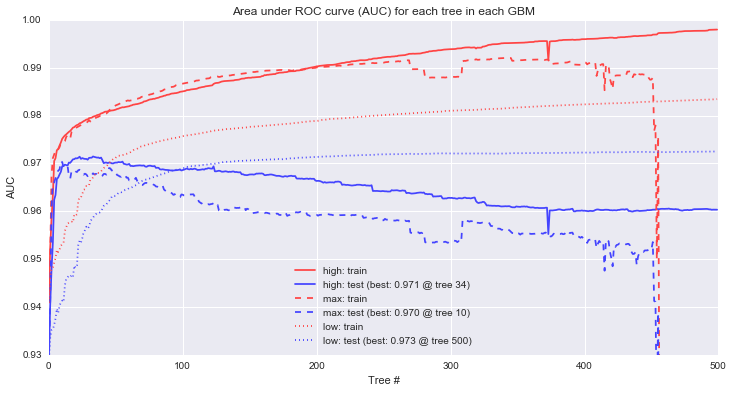

In [6]:
plt.figure(figsize=(12,6))
for marker, (mname, preds) in zip(["-", "--", ":"], stage_preds.iteritems()):
    for c, (tt_set, target) in zip(['#ff4444', '#4444ff'], [('train', train_t), ('test', test_t)]):
        aucs = map(lambda x: roc_auc_score(target, x[:,1]), preds[tt_set])
        label = "%s: %s" % (mname, tt_set) + (" (best: %.3f @ tree %d)" % (max(aucs), np.array(aucs).argmax()+1) if tt_set == 'test' else "")
        plt.plot(aucs, marker, c=c, label=label)
plt.ylim(0.93, 1)
plt.title("Area under ROC curve (AUC) for each tree in each GBM")
plt.xlabel("Tree #")
plt.ylabel("AUC")
plt.legend(loc="lower center")
plt.show()

### Next up...

In this post, we've gone through some of the mechanical aspects and considerations of fitting GBMs. The next post in the series will focus more on understanding exactly how GBMs are making decisions and contrasting that with other model types. The plots below are a teaser of things to come. 

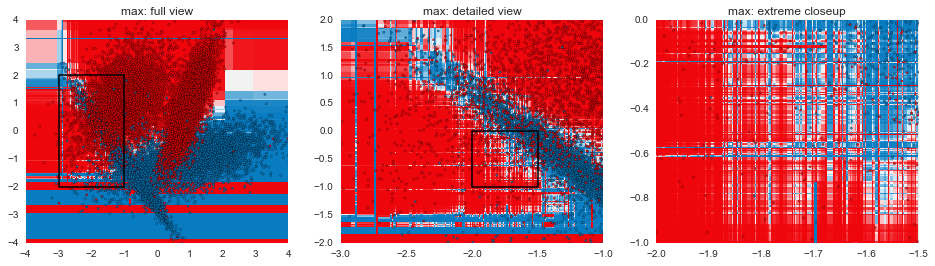

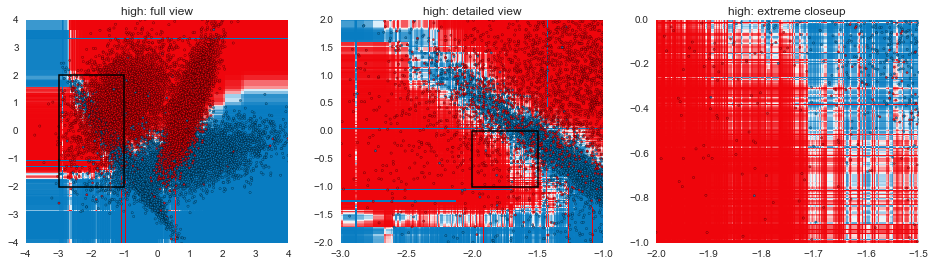

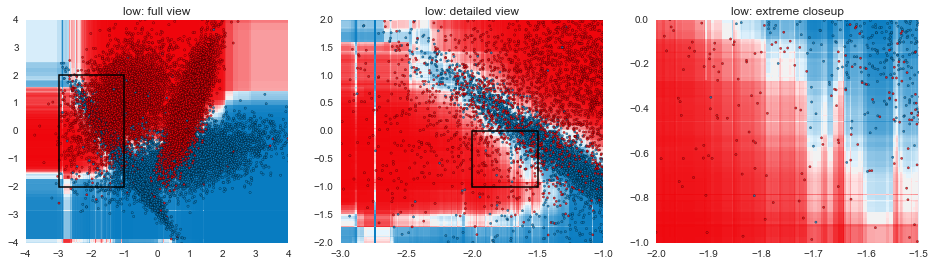

In [7]:
def gen_plot(mname, model, xlim=(-4, 4), ylim=(-4, 4), gridsize=0.02, marker="."):
    xx, yy = np.meshgrid(np.arange(xlim[0], xlim[1], gridsize),
                         np.arange(ylim[0], ylim[1], gridsize))
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    Z = model.predict_proba(zip(xx.ravel(), yy.ravel()))
    plt.title(mname)
    plt.pcolormesh(xx, yy, Z[:,1].reshape(xx.shape), cmap=my_cm)
    plt.scatter(raw_data[:,0], raw_data[:,1], c=raw_target, alpha=0.8, marker=marker, cmap=my_cm)

for mname, model in models:
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    gen_plot("%s: full view" % mname, model)
    plt.axhspan(-2, 2, 0.125, 0.375, fill=False, lw=1.5)
    
    plt.subplot(1,3,2)
    gen_plot("%s: detailed view" % mname, model, (-3, -1), (-2, 2), 0.005)
    plt.axhspan(-1, 0, 0.5, 0.75, fill=False, lw=1.5)
    
    plt.subplot(1,3,3)
    gen_plot("%s: extreme closeup" % mname, model, (-2, -1.5), (-1, 0), 0.00125)

    plt.show()

*Code for visualizing decision boundaries modified from [the excellent scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).*